<a href="https://colab.research.google.com/github/amedekaemperor/PyTorch/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!python -c 'import torch; print(torch.__version__)'
!python -c 'import torch; print(torch.version.cuda)'
!nvidia-smi

2.5.0+cu121
12.1
Thu Nov 14 15:33:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------

In [9]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.5.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.5.0+cu121.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.0+cu121.html


In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

![](https://miro.medium.com/v2/resize:fit:593/1*GffxpaoQWG8VPteziCQm5A.png)

In [30]:
data = dataset[0]
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {len(data.y.unique())}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Average node degree: 3.90
Is undirected: True


In [19]:
print(data.x.shape)
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [33]:
print(data.y.shape)
data.y

torch.Size([2708])


tensor([3, 4, 4,  ..., 3, 3, 3])

In [34]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [36]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(42)

    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.out = Linear(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)

    x = self.conv2(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)

    x = F.softmax(x, dim=1)

    return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [42]:
model = GCN(hidden_channels=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

losses = []
for epoch in range(1001):
  loss = train()
  losses.append(loss)
  if epoch % 100 == 0:
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 2.7726
Epoch: 100, Loss: 2.7098
Epoch: 200, Loss: 2.6928
Epoch: 300, Loss: 2.5736
Epoch: 400, Loss: 2.4875
Epoch: 500, Loss: 2.4375
Epoch: 600, Loss: 2.5002
Epoch: 700, Loss: 2.4465
Epoch: 800, Loss: 2.3824
Epoch: 900, Loss: 2.4159
Epoch: 1000, Loss: 2.3825


<Axes: >

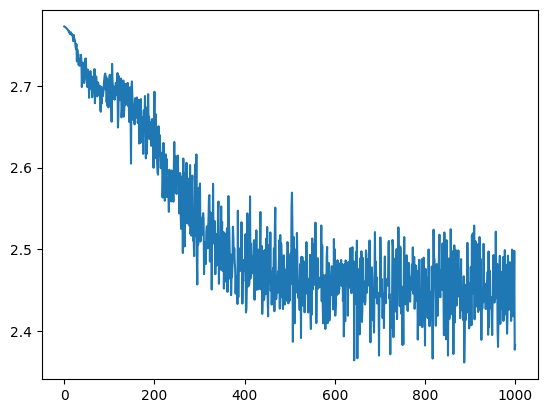

In [43]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
sns.lineplot(x=loss_indices, y=losses_float)


In [48]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')
print(model(data.x, data.edge_index).shape)

Test Accuracy: 0.8000
torch.Size([2708, 16])
